## Predicting Damage with Decision Trees

**Goal**: Build a classification model that will predict whether a building will be severely damagaed or not severely damaged. 

In [2]:
import sqlite3
import warnings

import matplotlib.pyplot as plt 
import pandas as pd 
from category_encoders import OrdinalEncoder
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted

#### Prepare Data

Import Data

The function below imports data from sqlite server:

In [ ]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

Example importing:

df = wrangle("/some/dir/some/data.sqlite")
df.head()

Importing csv with pd

In [3]:
def wrangle2(filepath):
      # Read data into DataFrame
    df = pd.read_csv(filepath).set_index("b_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)
    
    return df


In [5]:
df = wrangle2("data/df.csv")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0


Assert importation:

In [7]:
assert df.shape[0] == 70836, f"`df` should have 70,836 rows, not {df.shape[0]}."
assert df.shape[1] == 12, f"`df` should have 12 columns, not {df.shape[1]}."

Split

Split features(X) and target(y):

In [8]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

Assert spliting data into X and y:

In [9]:
assert X.shape == (70836, 11), f"The shape of `X` should be (70836, 11), not {X.shape}."
assert y.shape == (70836,), f"The shape of `y` should be (70836,), not {y.shape}."

Randomized Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=42
)

Assert split:

In [13]:
assert X_train.shape == (
    56668,
    11,
), f"The shape of `X_train` should be (56668, 11), not {X_train.shape}."
assert y_train.shape == (
    56668,
), f"The shape of `y_train` should be (56668,), not {y_train.shape}."
assert X_test.shape == (
    14168,
    11,
), f"The shape of `X_test` should be (14168, 11), not {X_test.shape}."
assert y_test.shape == (
    14168,
), f"The shape of `y_test` should be (14168,), not {y_test.shape}."

Divide X_train and y_train into training and validation sets using a randomized train-test split:

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.2, random_state=42
)

Assert split:

In [15]:
assert X_train.shape == (
    45334,
    11,
), f"The shape of `X_train` should be (45334, 11), not {X_train.shape}."
assert y_train.shape == (
    45334,
), f"The shape of `y_train` should be (45334,), not {y_train.shape}."
assert X_val.shape == (
    11334,
    11,
), f"The shape of `X_val` should be (11334, 11), not {X_val.shape}."
assert y_val.shape == (
    11334,
), f"The shape of `y_val` should be (11334,), not {y_val.shape}."

#### Build Model

Baseline Model

In [16]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


Iterate

Decision Tree Classifier

In [53]:
# Building the model
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42)
)

# Fitting the model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
                                          'data_type': dtype('O'),
                                          'mapping': Rectangular                         1
T-shape                             2
Square                              3
L-shape                             4
Multi-projected                     5
U-shape                             6
E-shape                             7
H-shape                             8
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone        1
RC           2
Brick        3
Adobe/mud    4
Timber       5
Bamboo       6
Other        7
NaN         -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

Evaluate Model

In [54]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_val, y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.98
Validation Accuracy: 0.64


Tree Depth

In [56]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 56


Hyperparameter Tuning 1

In [58]:
# Instantiate a range of values for the tree depth
depth_hyperparams = range(1, 50, 2)

In [59]:
# Assertion
assert (
    len(list(depth_hyperparams)) == 25
), f"`depth_hyperparams` should contain 25 items, not {len(list(depth_hyperparams))}."
assert (
    list(depth_hyperparams)[0] == 1
), f"`depth_hyperparams` should begin at 1, not {list(depth_hyperparams)[0]}."
assert (
    list(depth_hyperparams)[-1] == 49
), f"`depth_hyperparams` should end at 49, not {list(depth_hyperparams)[-1]}."

Hyperparameter Tuning II

Calculating a new training and validation accuracy scores everytime a model is trained.

In [60]:
# training and validation accuracy scores lists
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # A model with `max_depth` of `d`
    test_model = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(random_state=42, max_depth=d)
    )
    #Fitting to training data
    test_model.fit(X_train, y_train)
    
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6983279657652093, 0.7097542683195835, 0.7155115365950501]
Validation Accuracy Scores: [0.698782424563261, 0.7129874713252161, 0.7162519851773425]


In [62]:
# Assertions
assert (
    len(training_acc) == 25
), f"`training_acc` should contain 25 items, not {len(training_acc)}."
assert (
    len(validation_acc) == 25
), f"`validation_acc` should contain 25 items, not {len(validation_acc)}."

Validation Curve

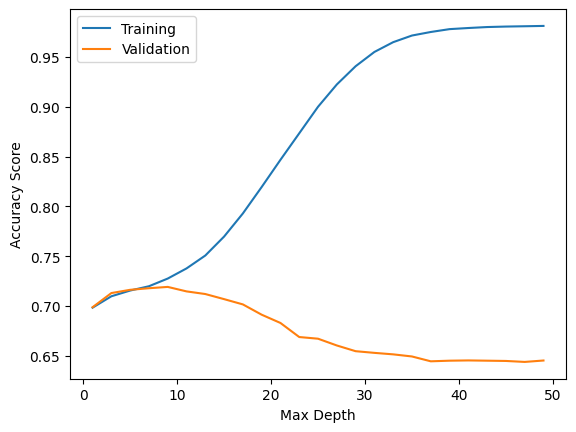

In [64]:
plt.plot(depth_hyperparams, training_acc, label="Training")
plt.plot(depth_hyperparams, validation_acc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

- In the training data, as we introduce more and more flexibility into the model, the model is able to acurately predict that training data.

- On the contrary, the accuracy starts by going up, upto around a depth of 6, then the accuracy starts decreasing. 
- Therefore, the best max depth is at the point just before the divergent, with a max depth = 6.
- Next step will be to train the model with the best hyperparameter, max depth = 6.

### Evaluate

In [66]:
test_model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42, max_depth=6)
    )
#Fitting to training data
test_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
                                          'data_type': dtype('O'),
                                          'mapping': Rectangular                         1
T-shape                             2
Square                              3
L-shape                             4
Multi-projected                     5
U-shape                             6
E-shape                             7
H-shape                             8
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone        1
RC           2
Brick        3
Adobe/mud    4
Timber       5
Bamboo       6
Other        7
NaN         -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])